In [2]:
from symred.projection import S3_projection, QubitTapering, CS_VQE_LW
from symred.symplectic import *
from symred.utils import exact_gs_energy
from symred.utils import gf2_gaus_elim, gf2_basis_for_gf2_rref
from symred.chem import FermionicHamilt, FermioniCC, PySCFDriver, geometry_from_pubchem
from openfermion import get_fermion_operator, jordan_wigner, hermitian_conjugated, QubitOperator
from matplotlib import pyplot as plt
from functools import reduce
import json

In [3]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
#with open('data/score_data.json', 'r') as infile:
#    scoring_data = json.load(infile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2-_STO-3G_SINGLET', 'BH3_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3

# Calculate the molecule parameters

In [30]:
# Set molecule parameters
speciesname = 'HCl_STO-3G_SINGLET'
#print(speciesname in scoring_data)
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms = mol_data['atoms']
coords = mol_data['coords']
basis = mol_data['basis']
multiplicity = mol_data['multiplicity'] #'6-31g' #'cc-pVDZ' #
charge = mol_data['charge']
geometry = list(zip(atoms, coords))
#geometry = geometry_from_pubchem('N2')

xyz_file = str(len(atoms))+'\n '

for atom, coords in geometry:
    xyz_file += '\n'+atom+'\t'
    xyz_file += '\t'.join(list(map(str, coords)))
#xyz_file = '4\n \nH\t0\t0\t0\nH\t2.45366053071732\t0\t0\nH\t2.45366053071732\t2.45366053071732\t0\nH\t0\t2.45366053071732\t0\n'
print('Molecule geometry:')
print(xyz_file[4:])

Molecule geometry:
Cl	0.0	0.0	0.07452
H	0.0	0.0	-1.266846


In [31]:
convergence = 1e-6; max_hf_cycles=100_000; ram = 8_000
run_mp2  = True; run_cisd = False; run_ccsd = True; run_fci  = True#False

pyscf_obj = PySCFDriver(xyz_file,
                        basis,
                        #convergence=convergence,
                        charge=charge,
                        #max_ram_memory=ram,
                        #max_hf_cycles=max_hf_cycles,                   
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)

pyscf_obj.run_pyscf()

print('HF converged?  ', pyscf_obj.pyscf_hf.converged)
print('CCSD converged?', pyscf_obj.pyscf_ccsd.converged)
if run_fci:
    print('FCI converged? ', pyscf_obj.pyscf_fci.converged)
    fci_energy = pyscf_obj.pyscf_fci.e_tot
else:
    fci_energy = None
    
hf_energy = pyscf_obj.pyscf_hf.e_tot
mp2_energy = pyscf_obj.pyscf_mp2.e_tot
ccsd_energy = pyscf_obj.pyscf_ccsd.e_tot

print()
print(f'HF energy: {hf_energy}')
print(f'MP2 energy: {mp2_energy}')
print(f'CCSD energy: {ccsd_energy}')
print(f'FCI energy: {fci_energy}')

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy: -455.1354456708123
MP2 energy: -455.1497064364202
CCSD energy: -455.1570668271788
FCI energy: -455.15706679314906


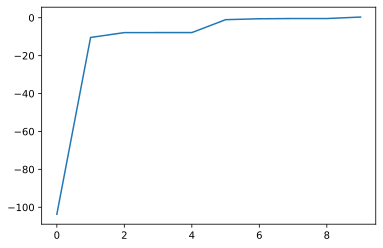

In [32]:
plt.plot(pyscf_obj.pyscf_hf.mo_energy)

# Build the Hamiltonian and Coupled-Cluster operator 

In [33]:
from symred.utils import QubitOperator_to_dict

# build fermionic Hamiltonian
H_fermion = FermionicHamilt(pyscf_obj.pyscf_hf)
T_fermion = FermioniCC(pyscf_obj.pyscf_ccsd)
H_fermion.build_operator()
T_fermion.build_operator()

n_qubits = H_fermion.n_qubits
print('Number of qubits:', n_qubits)

H = get_fermion_operator(H_fermion.fermionic_molecular_hamiltonian)
T = T_fermion.fermionic_cc_operator
#T -= hermitian_conjugated(T)

# map to QubitOperator via Jordan-Wigner
H_jw = jordan_wigner(H)
T_jw = jordan_wigner(T)

# convert to PauliwordOp
H_q = PauliwordOp(QubitOperator_to_dict(H_jw, n_qubits))
T_q = PauliwordOp(QubitOperator_to_dict(T_jw, n_qubits))
T_q.coeff_vec = T_q.coeff_vec.imag

Number of qubits: 20


# Taper the Hamiltonian

In [34]:
taper_hamiltonian = QubitTapering(H_q)

print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian.\n')
print('The symmetry generators are\n')
print(taper_hamiltonian.symmetry_generators)
print('\nand may be rotated via a sequence of Clifford pi/2 rotations\n')
print(taper_hamiltonian.stabilizers.stabilizer_rotations)
print('\nonto the single-qubit Pauli operators\n')
print(taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis())

We are able to taper 3 qubits from the Hamiltonian.

The symmetry generators are

1.0000000000+0.0000000000j ZIZIZIIZIZZIZIIZIZZI +
1.0000000000+0.0000000000j IZIZIZIZIZIZIZIZIZIZ +
1.0000000000+0.0000000000j IIIIIIZZZZIIIIZZZZII

and may be rotated via a sequence of Clifford pi/2 rotations

[('IIIIIIYZZZIIIIZZZZII', None), ('YIZIZIIZIZZIZIIZIZZI', None), ('IYIZIZIZIZIZIZIZIZIZ', None)]

onto the single-qubit Pauli operators

-1.0000000000+0.0000000000j XIIIIIIIIIIIIIIIIIII +
-1.0000000000+0.0000000000j IXIIIIIIIIIIIIIIIIII +
-1.0000000000+0.0000000000j IIIIIIXIIIIIIIIIIIII


In [35]:
hf_array = H_fermion.hf_comp_basis_state
taper_hamiltonian.stabilizers.update_sector(hf_array)
print(f'The symmetry sector corresponding with the reference {hf_array} is {taper_hamiltonian.stabilizers.coeff_vec}')

The symmetry sector corresponding with the reference [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0] is [-1 -1  1]


In [36]:
ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)
#sor_tap = taper_hamiltonian.taper_it(aux_operator=sor_ham, ref_state=hf_array)
#sor_tap.coeff_vec/=np.linalg.norm(sor_tap.coeff_vec)
ucc_tap = taper_hamiltonian.taper_it(aux_operator=T_q, ref_state=hf_array)
n_taper = taper_hamiltonian.n_taper
tapered_qubits   = taper_hamiltonian.stab_qubit_indices
untapered_qubits = taper_hamiltonian.free_qubit_indices
hf_tapered = taper_hamiltonian.tapered_ref_state

print(f'The tapered Hartree-Fock state is', QuantumState([hf_tapered]))

The tapered Hartree-Fock state is  1.0000000000 |11111111111111100>


# Build the CS-VQE model

In [37]:
cs_vqe_lw = CS_VQE_LW(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap)

# Bias the Hamiltonian around the HOMO-LUMO gap

The HOMO-LUMO gap lies between spin-orbitals 17 and 18


<BarContainer object of 20 artists>

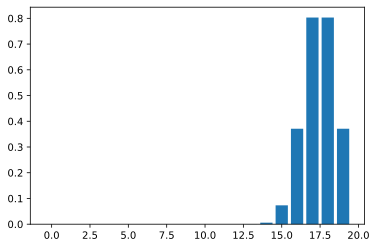

In [38]:
from symred.projection import HamiltonianBiasing, StabilizerIdentification

HL_gap = np.where(hf_array==0)[0][0]-.5
ham_biasing = HamiltonianBiasing(base_operator=H_q, HOMO_LUMO_gap=HL_gap)

ham_biasing.HOMO_bias = .5
ham_biasing.LUMO_bias = .5
#ham_biasing.separation = 1

print(f'The HOMO-LUMO gap lies between spin-orbitals {int(HL_gap-1/2)} and {int(HL_gap+1/2)}')
plt.bar(np.arange(H_q.n_qubits),ham_biasing.HOMO_LUMO_bias_curve())

In [39]:
print(ham_biasing.HOMO_LUMO_biased_operator().sort(key='magnitude'))

1.6456674155+0.0000000000j IIIIIIIIIIIIXIIIIIXI +
1.6347512492+0.0000000000j IIIIIIIXIIIIIIIIIXII +
1.3950973962+0.0000000000j IIIIXIIIIIIIIIIIIIXI +
1.1176202179+0.0000000000j IIIIIIIIIIXIIIIIIIXI +
0.8564187786+0.0000000000j IIIIIIIIIXIIIIIIIXII +
0.7602842494+0.0000000000j IIIIIIIIIIIIIXIIIIIX +
0.7548976857+0.0000000000j IIIIIIXIIIIIIIIIXIII +
0.6442299990+0.0000000000j IIIIIXIIIIIIIIIIIIIX +
0.5160962157+0.0000000000j IIIIIIIIIIIXIIIIIIIX +
0.4551901117+0.0000000000j IIXIIIIIIIIIIIIIIIXI +
0.3954782443+0.0000000000j IIIIIIIIXIIIIIIIXIII +
0.2101983174+0.0000000000j IIIXIIIIIIIIIIIIIIIX +
0.1654427949+0.0000000000j IIIIIIIIIIIIXXIIIIXX +
0.1490167448+0.0000000000j IIIIIIIIIXIIIIIXIIII +
0.1296485744+0.0000000000j IIIIIIIIIIXXIIIIXXII +
0.1053428906+0.0000000000j XIIIIIIIIIIIIIIIIIXI +
0.0780673748+0.0000000000j IIIIIIIXIIIIIIIXIIII +
0.0726009155+0.0000000000j IIIIIIIIIIXXIIIIIIXX +
0.0724577079+0.0000000000j IIIIIIIIIIIXXXIIIIXI +
0.0579084527+0.0000000000j IIIIIIIIIIIXIIIIXXXI +


In [95]:
heatmap_data={}
steps=10

for q in range(1, 7):
    print(f'{q}-qubit')
    qubit_data = []
    for a in np.linspace(0, 1, steps):
        for b in np.linspace(0, 1, steps):
            ham_biasing.HOMO_bias = a
            ham_biasing.LUMO_bias = b
            H_bias = taper_hamiltonian.taper_it(aux_operator=ham_biasing.HOMO_LUMO_biased_operator(), ref_state=hf_array)
            stabilizers = StabilizerIdentification(H_bias)
            S = stabilizers.symmetry_basis_by_subspace_dimension(n_sim_qubits=q)
            stab_score = cs_vqe_lw.basis_score(S)
            ham_cs = cs_vqe_lw.project_onto_subspace(S)
            matrix = ham_cs.to_sparse_matrix
            e = exact_gs_energy(matrix)[0]
            error = e-fci_energy

            qubit_data.append((a,b,stab_score,error))
        heatmap_data[q] = qubit_data

1-qubit
2-qubit
3-qubit
4-qubit
5-qubit
6-qubit


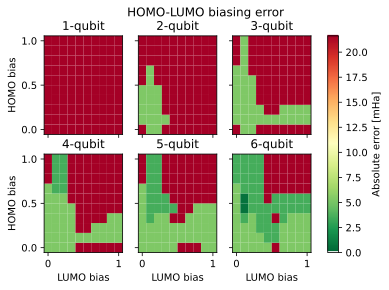

In [105]:
n_rows=2
n_cols=3

fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, sharey=True, sharex=True)

for q, data in heatmap_data.items():
    i, j=(q-1)//n_cols, (q-1)%n_cols
    # generate 2 2d grids for the x & y bounds
    x,y,z_score,z_error = zip(*data)
    x = np.array(x).reshape(steps,steps)
    y = np.array(y).reshape(steps,steps)
    #z_score = np.array(z_score).reshape(steps,steps)
    z_error = np.array(z_error).reshape(steps,steps)
    
    c = axes[i, j].pcolormesh(x, y, z_error*1000, cmap='RdYlGn_r', vmin=0, vmax=(hf_energy-fci_energy)*1000, shading='auto')
    axes[i, j].set_title(f'{q}-qubit')
    # set the limits of the plot to the limits of the data
    #axes[i, j].axis([x.min(), x.max(), y.min(), y.max()])
    if i==1:
        axes[i, j].set_xlabel('LUMO bias')
    if j==0:
        axes[i, j].set_ylabel('HOMO bias')

fig.colorbar(c, ax=axes, label='Absolute error [mHa]')
fig.suptitle('HOMO-LUMO biasing error')
plt.show()

In [ ]:
# generate 2 2d grids for the x & y bounds
x,y,z_score,z_error = zip(*heatmap_data)
x = np.array(x).reshape(steps,steps)
y = np.array(y).reshape(steps,steps)
z_score = np.array(z_score).reshape(steps,steps)
z_error = np.array(z_error).reshape(steps,steps)

TypeError: '>=' not supported between instances of 'NoneType' and 'NoneType'

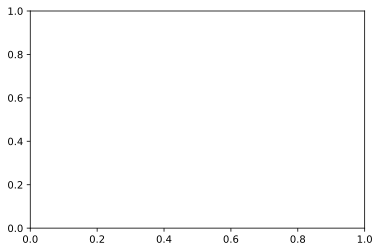

In [43]:
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z_error, cmap='RdYlGn_r', vmin=0, vmax=z_error.max())
ax.set_title('Hamiltonian HOMO-LUMO biasing error')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.set_xlabel('LUMO bias')
ax.set_ylabel('HOMO bias')
fig.colorbar(c, ax=ax)
plt.show()

/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


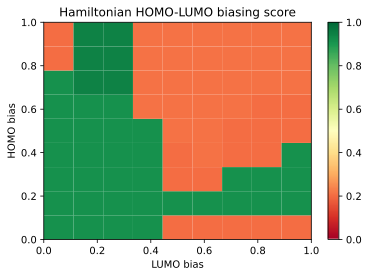

In [44]:
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z_score, cmap='RdYlGn', vmin=0, vmax=1)
ax.set_title('Hamiltonian HOMO-LUMO biasing score')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.set_xlabel('LUMO bias')
ax.set_ylabel('HOMO bias')
fig.colorbar(c, ax=ax)
plt.show()

In [26]:
from scipy.optimize import minimize

def stabilizer_search(n_sim_qubits):
    
    def get_stabilizers(x):
        ham_biasing.HOMO_bias = x
        ham_biasing.LUMO_bias = x
        H_bias = taper_hamiltonian.taper_it(aux_operator=ham_biasing.HOMO_LUMO_biased_operator(), ref_state=hf_array)
        stabilizers = StabilizerIdentification(H_bias)
        S = stabilizers.symmetry_basis_by_subspace_dimension(n_sim_qubits)
        return(S)
    
    def objective(x):
        S = get_stabilizers(x)
        stab_score = cs_vqe_lw.basis_score(S)
        return -stab_score
    
    opt_out = minimize(objective, x0=[0], bounds=[(0,1)], method='POWELL')
    stab_score=-opt_out['fun']
    print(f'Optimal score w(S)={stab_score}')
    S=get_stabilizers(*opt_out['x'])
    return S

#plt.plot(bias_curve(np.arange(ham_tap.n_qubits), u_sig=np.pi/2, l_sig=np.pi/2,sep=10))
#stabs = stabilizer_search(20)
#print(stabs)

#ham_cs = cs_vqe_lw.project_onto_subspace(stabs)
#matrix = ham_cs.to_sparse_matrix
#e = exact_gs_energy(matrix)[0]
#error = e-fci_energy

#print(f'Energy error wrt FCI is {error} Ha')

Optimal score w(S)=0.9974143840351909
1.0000000000+0.0000000000j IZIZIZIZIZIZIZIZIZIZIZIZ +
1.0000000000+0.0000000000j IIZIIIIIIIIIIIIIIIIIIIII +
1.0000000000+0.0000000000j IIIIZIIIIIIIIIIIIIIIIIII +
1.0000000000+0.0000000000j IIIIIIZIIIIIIIIIIIIIIIII


In [28]:
scores = []

for i in range(1, ham_tap.n_qubits):
    print(i)
    S = stabilizer_search(i)
    stab_score = cs_vqe_lw.basis_score(S)
    scores.append(stab_score)

1
Optimal score w(S)=0.038744953461618215
2
Optimal score w(S)=0.13410966764778218
3
Optimal score w(S)=0.13425356218824666
4
Optimal score w(S)=0.18871152628688065
5
Optimal score w(S)=0.330997814044604
6
Optimal score w(S)=0.33113021259662617
7
Optimal score w(S)=0.36535137362570513
8
Optimal score w(S)=0.5999648512881428
9
Optimal score w(S)=0.34045188215886496
10
Optimal score w(S)=0.6009697030334085
11
Optimal score w(S)=0.6004950495341715
12
Optimal score w(S)=0.34297726071063506
13
Optimal score w(S)=0.6017287557199957
14
Optimal score w(S)=0.6115920957926457
15
Optimal score w(S)=0.6310130858345053
16
Optimal score w(S)=0.6870122835997081
17
Optimal score w(S)=0.7112051131477608
18
Optimal score w(S)=0.763198577007926
19
Optimal score w(S)=0.7642850597098485
20
Optimal score w(S)=0.9974143840351909
21
Optimal score w(S)=0.9974148025000548
22
Optimal score w(S)=0.9981864976974021
23
Optimal score w(S)=0.8951315398615253


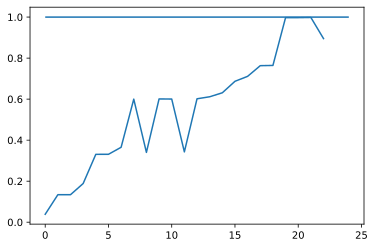

In [29]:
plt.plot(scores)
plt.hlines(1, 0, ham_tap.n_qubits)

In [94]:
ref_energy = fci_energy
max_sim_q = 10

scores = []
energy = []

for i in range(1, ham_tap.n_qubits):
    try:
        stabilizers =  find_stabilizers(n_sim_qubits=i, region=[0,hlg_sort.n_terms])
        stab_score = cs_vqe_lw.basis_score(stabilizers)
        scores.append(stab_score)
        print('Basis score (min:0, max:1):', stab_score)
        if i<=max_sim_q:
            ham_cs = cs_vqe_lw.project_onto_subspace(stabilizers)
            print(f'Number of qubits in contextual subspace: {ham_cs.n_qubits}/{ham_tap.n_qubits}')
            matrix = ham_cs.to_sparse_matrix
            e = exact_gs_energy(matrix)[0]
            print('Error from CCSD:', e-ref_energy)
            energy.append(e)
    except:
        print(i, 'did not work')

1 did not work
2 did not work
3 did not work
4 did not work
5 did not work
6 did not work
7 did not work
8 did not work
9 did not work


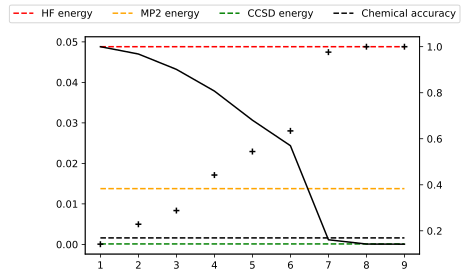

In [254]:
from matplotlib import pyplot as plt
#plt.style.use('ggplot')

fig,energy_axis = plt.subplots()
X=np.arange(1, ham_tap.n_qubits)

Y_energy=np.array(energy)-ref_energy
energy_axis.plot(X[:max_sim_q], Y_energy, color='black')
energy_axis.hlines(hf_energy-ref_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(mp2_energy-ref_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(ccsd_energy-ref_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
energy_axis.hlines(0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

#energy_axis.set_ylim(1e-15, 1e-0) 
#energy_axis.set_yscale('log')

score_axis = energy_axis.twinx()
Y_scores=np.array(scores)
score_axis.scatter(X, Y_scores, color='black', marker='+')

#energy_axis.set_xticks(X)

fig.legend(ncol=4)
plt.show()

In [42]:
#with open('data/score_data.json', 'r') as infile:
#    scoring_data = json.load(infile)
    
#scoring_data

In [43]:
#speciesname = 'H2O_6-31g_SINGLET'

#scoring_data[speciesname] = {
#    'n_qubits_pre_taper': H_q.n_qubits, 
#    'n_qubits_post_taper': ham_tap.n_qubits,
#    'hf_energy': hf_energy,
#    'mp2_energy': mp2_energy,
#    'ccsd_energy': ccsd_energy,
#    'fci_energy': fci_energy,
#    'cs_vqe_energies': energy,
#    'stabilizer_score': scores
#}

#scoring_data

In [44]:
#with open('data/score_data.json', 'w') as outfile:
#    json.dump(scoring_data, outfile)

In [17]:
from scipy.special import comb

def random_stabs(n_stabs):
    Z_block = np.random.randint(0,2,(n_stabs, ham_tap.n_qubits))
    S = StabilizerOp(np.hstack([np.zeros_like(Z_block), Z_block]), np.ones(n_stabs))
    return S

def score_vs_energy(n_stabs):
    S = random_stabs(n_stabs)
    ucc_stab_score = cs_vqe_lw.basis_score(S)
    ham_stab_score = cs_vqe_lw_2.basis_score(S)
    ham_cs = cs_vqe_lw.project_onto_subspace(S)
    matrix = ham_cs.to_sparse_matrix
    e = exact_gs_energy(matrix)[0]
    return ham_stab_score, ucc_stab_score, e

data={}

for n_stabs in range(1, ham_tap.n_qubits):
    print(f'Randomizing {n_stabs} stabilizer(s)')
    count=0
    results = []
    while count<=2**ham_tap.n_qubits:
        try:
            results.append(score_vs_energy(n_stabs))
            count+=1
        except:
            pass
    data[ham_tap.n_qubits-n_stabs] = results

Randomizing 1 stabilizer(s)
Randomizing 2 stabilizer(s)
Randomizing 3 stabilizer(s)
Randomizing 4 stabilizer(s)
Randomizing 5 stabilizer(s)
Randomizing 6 stabilizer(s)
Randomizing 7 stabilizer(s)
Randomizing 8 stabilizer(s)


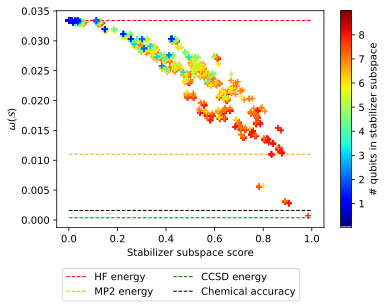

In [23]:
from matplotlib.pyplot import Normalize

fig,axis = plt.subplots()

increments = []

for n_qubits,results in data.items():
    ratio = n_qubits/ham_tap.n_qubits
    increments.append(ratio)
    c = plt.cm.jet(ratio)
    X_ham, X_ucc, Y = zip(*results)
    X = np.array(X_ucc)
    Y = np.array(Y) - fci_energy
    axis.scatter(
        X, 
        Y, 
        marker='+', 
        color=c, 
        zorder=1,#n_qubits,
        alpha=0.9)
    
keys = list(data.keys())
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(), cmap='jet'), 
                     ax=axis, label='# qubits in stabilizer subspace', ticks=increments)#, fraction=0.78)
cbar.ax.set_yticklabels(keys)

axis.set_xlabel('Stabilizer subspace score')
axis.set_ylabel('$\omega(\mathcal{S})$')

axis.hlines(hf_energy-fci_energy, 0, 1, ls='--', lw=1, color='red', zorder=0, label='HF energy')
axis.hlines(mp2_energy-fci_energy, 0, 1, ls='--', lw=1, color='orange', zorder=0, label='MP2 energy')
axis.hlines(ccsd_energy-fci_energy, 0, 1, ls='--', lw=1, color='green', zorder=0, label='CCSD energy')
axis.hlines(0.0016, 0, 1, ls='--', lw=1, color='black', zorder=0, label='Chemical accuracy')

fig.legend(ncol=2, bbox_to_anchor=(0.7,0))

In [31]:
#with open('data/score_vs_energy.json', 'r') as infile:
#    score_vs_energy = json.load(infile)
#    
#score_vs_energy.keys()

In [32]:
#score_vs_energy[speciesname] = {
#    'n_qubits_pre_taper': H_q.n_qubits, 
#    'n_qubits_post_taper': ham_tap.n_qubits,
#    'hf_energy': hf_energy,
#    'mp2_energy': mp2_energy,
#    'ccsd_energy': ccsd_energy,
#    'fci_energy': fci_energy,
#    'ham_score_ucc_score_cs_energy':data
#}
#score_vs_energy

In [33]:
#with open('data/score_vs_energy.json', 'w') as outfile:
#    json.dump(score_vs_energy, outfile)